# Notes for user:

*   This notebook will use the dataset COVID-19 and forex to predict the forex spot price of a currency pair.
*   What to ask user before using this application:
*   What currency pair are you interested in? USD/GBP (This layout means that the base currency is USD)
*   The currency the user wants to look at is how much the USD is worth to the GBP.
*   Therefore, we look at the death rates in the US and the UK.
*   To do: x_train and validation dataset


In [ ]:
# Use some functions from tensorflow_docs
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-opisbl4r
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-opisbl4r
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0adae1941b3a1b3c0b781b94d96f4476892a44620_-cp36-none-any.whl size=126412 sha256=5ed412bb7cb9acca55143e939074ef7889186a835dd02c129b88c5f854eccb8d
  Stored in directory: /tmp/pip-ephem-wheel-cache-d5jlz0jg/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [ ]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.2.0


In [ ]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

# Data Collection


In [ ]:
# Importing covid_dataset using pandas. Droping null values.
covid_dataset_data= pd.read_csv('covid.csv', na_values = "?", comment='\t', skipinitialspace=True)
covid_dataset = covid_dataset_data.copy()
# covid_dataset = covid_dataset.dropna()
covid_dataset.head()

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [ ]:
# Trying to isolate location/country based on currency in question
# We are looking at pound and sterling therefore need to isolate 'United Kingdom' & 'United States' in location column
# Problem: Informaiton prints up until 'Trinidad and Tobago' for some reason – can print 'Togo'. Therefore cannot print United Kingdom or United States
us_death_rates = covid_dataset.loc[covid_dataset.location=='United States', ['location', 'date', 'total_deaths', 'total_cases', 'cvd_death_rate']]
us_death_rates.head()

,location,date,total_deaths,total_cases,cvd_death_rate
26490,United States,2019-12-31,0.0,0.0,151.089
26491,United States,2020-01-01,0.0,0.0,151.089
26492,United States,2020-01-02,0.0,0.0,151.089
26493,United States,2020-01-03,0.0,0.0,151.089
26494,United States,2020-01-04,0.0,0.0,151.089


In [ ]:
# us_death_rates = covid_dataset.loc[covid_dataset.location=='Zimbabwe', ['location', 'date', 'total_deaths','total_cases','cvd_death_rate']]
# us_death_rates.head()

In [ ]:
us_death_rates.shape

(187, 5)

In [ ]:
# Import forex
forex_dataset_data= pd.read_csv('GBP_USD.csv', na_values = "?", comment='\t', skipinitialspace=True)
forex_dataset = forex_dataset_data.copy()
# forex_dataset = forex_dataset_data.dropna()


# Data Preprocessing / Data Cleaning & Collating

In [ ]:
# Filter dataset
forex_dataset.pop('Open')
forex_dataset.pop('High')
forex_dataset.pop('Low')
forex_dataset.pop('Change %')

0       0.12%
1      -0.05%
2       0.59%
3       0.83%
4      -0.30%
        ...  
150    -0.15%
151     0.40%
152     0.85%
153     0.44%
154     0.02%
Name: Change %, Length: 155, dtype: object

In [ ]:
forex_dataset.tail()

,Date,Price
150,"Dec 06, 2019",1.3137
151,"Dec 05, 2019",1.3157
152,"Dec 04, 2019",1.3104
153,"Dec 03, 2019",1.2994
154,"Dec 02, 2019",1.2937


In [ ]:
# Isolate covid_date
import time 
us_date = us_death_rates['date']
new_us_dates = [time.strptime(x.replace("-"," "), '%Y %m %d')for x in us_date]
us_death_rates['date'] = new_us_dates
us_death_rates.head()


,location,date,total_deaths,total_cases,cvd_death_rate
26490,United States,"(2019, 12, 31, 0, 0, 0, 1, 365, -1)",0.0,0.0,151.089
26491,United States,"(2020, 1, 1, 0, 0, 0, 2, 1, -1)",0.0,0.0,151.089
26492,United States,"(2020, 1, 2, 0, 0, 0, 3, 2, -1)",0.0,0.0,151.089
26493,United States,"(2020, 1, 3, 0, 0, 0, 4, 3, -1)",0.0,0.0,151.089
26494,United States,"(2020, 1, 4, 0, 0, 0, 5, 4, -1)",0.0,0.0,151.089


In [ ]:
# Isolate forex_date
import time 
forex_date = forex_dataset['Date']
new_forex_dates = [time.strptime(x.replace(',', ""), '%b %d %Y')for x in forex_date]
forex_dataset['Date'] = new_forex_dates
forex_dataset.tail()


,Date,Price
150,"(2019, 12, 6, 0, 0, 0, 4, 340, -1)",1.3137
151,"(2019, 12, 5, 0, 0, 0, 3, 339, -1)",1.3157
152,"(2019, 12, 4, 0, 0, 0, 2, 338, -1)",1.3104
153,"(2019, 12, 3, 0, 0, 0, 1, 337, -1)",1.2994
154,"(2019, 12, 2, 0, 0, 0, 0, 336, -1)",1.2937


In [ ]:
print(len(forex_dataset))

155


In [ ]:
# Merging dates from two tables
dataset = pd.merge(left=forex_dataset, left_on='Date',
         right=us_death_rates, right_on='date')
dataset.tail()
len(dataset)


134

In [ ]:
# We pop the 'date' from the covid_dataset because this column starts later than the forex column
# We want to see the forex price before covid happened
dataset.pop('date')

0        (2020, 7, 3, 0, 0, 0, 4, 185, -1)
1        (2020, 7, 2, 0, 0, 0, 3, 184, -1)
2        (2020, 7, 1, 0, 0, 0, 2, 183, -1)
3       (2020, 6, 30, 0, 0, 0, 1, 182, -1)
4       (2020, 6, 29, 0, 0, 0, 0, 181, -1)
                      ...                 
129        (2020, 1, 6, 0, 0, 0, 0, 6, -1)
130        (2020, 1, 3, 0, 0, 0, 4, 3, -1)
131        (2020, 1, 2, 0, 0, 0, 3, 2, -1)
132        (2020, 1, 1, 0, 0, 0, 2, 1, -1)
133    (2019, 12, 31, 0, 0, 0, 1, 365, -1)
Name: date, Length: 134, dtype: object

In [ ]:
# Problem: This still starts at 2019,12,13 when we want 2019,12,02
# However this does not affect our data graph for some reason - scroll down
dataset.tail()

,Date,Price,location,total_deaths,total_cases,cvd_death_rate
129,"(2020, 1, 6, 0, 0, 0, 0, 6, -1)",1.3169,United States,0.0,0.0,151.089
130,"(2020, 1, 3, 0, 0, 0, 4, 3, -1)",1.3088,United States,0.0,0.0,151.089
131,"(2020, 1, 2, 0, 0, 0, 3, 2, -1)",1.3146,United States,0.0,0.0,151.089
132,"(2020, 1, 1, 0, 0, 0, 2, 1, -1)",1.3255,United States,0.0,0.0,151.089
133,"(2019, 12, 31, 0, 0, 0, 1, 365, -1)",1.3261,United States,0.0,0.0,151.089


In [ ]:
# Object means string
dataset['total_deaths']

0      128740.0
1      128062.0
2      127410.0
3      126140.0
4      125804.0
         ...   
129         0.0
130         0.0
131         0.0
132         0.0
133         0.0
Name: total_deaths, Length: 134, dtype: float64

In [ ]:
# View what date looks like
date = dataset['Date']
date.head()
len(date)

134

In [ ]:
# Splitting timestamp and isolating the date
dateFormatting = pd.DataFrame({'new_date': pd.date_range('2019-12-31', periods=len(date))})
# dateFormatting['new_date'] = [d.date() for d in dateFormatting['my_timestamp']]
# dateFormatting['new_time'] = [d.time() for d in dateFormatting['my_timestamp']]
print(dateFormatting)


      new_date
0   2019-12-31
1   2020-01-01
2   2020-01-02
3   2020-01-03
4   2020-01-04
..         ...
129 2020-05-08
130 2020-05-09
131 2020-05-10
132 2020-05-11
133 2020-05-12

[134 rows x 1 columns]


In [ ]:
# Convert date to list so that we can use the dates to plot on graph
my_xticks = dateFormatting['new_date'].tolist()
print(my_xticks)

[Timestamp('2019-12-31 00:00:00'), Timestamp('2020-01-01 00:00:00'), Timestamp('2020-01-02 00:00:00'), Timestamp('2020-01-03 00:00:00'), Timestamp('2020-01-04 00:00:00'), Timestamp('2020-01-05 00:00:00'), Timestamp('2020-01-06 00:00:00'), Timestamp('2020-01-07 00:00:00'), Timestamp('2020-01-08 00:00:00'), Timestamp('2020-01-09 00:00:00'), Timestamp('2020-01-10 00:00:00'), Timestamp('2020-01-11 00:00:00'), Timestamp('2020-01-12 00:00:00'), Timestamp('2020-01-13 00:00:00'), Timestamp('2020-01-14 00:00:00'), Timestamp('2020-01-15 00:00:00'), Timestamp('2020-01-16 00:00:00'), Timestamp('2020-01-17 00:00:00'), Timestamp('2020-01-18 00:00:00'), Timestamp('2020-01-19 00:00:00'), Timestamp('2020-01-20 00:00:00'), Timestamp('2020-01-21 00:00:00'), Timestamp('2020-01-22 00:00:00'), Timestamp('2020-01-23 00:00:00'), Timestamp('2020-01-24 00:00:00'), Timestamp('2020-01-25 00:00:00'), Timestamp('2020-01-26 00:00:00'), Timestamp('2020-01-27 00:00:00'), Timestamp('2020-01-28 00:00:00'), Timestamp('20

In [ ]:
dataset['Date']

0        (2020, 7, 3, 0, 0, 0, 4, 185, -1)
1        (2020, 7, 2, 0, 0, 0, 3, 184, -1)
2        (2020, 7, 1, 0, 0, 0, 2, 183, -1)
3       (2020, 6, 30, 0, 0, 0, 1, 182, -1)
4       (2020, 6, 29, 0, 0, 0, 0, 181, -1)
                      ...                 
129        (2020, 1, 6, 0, 0, 0, 0, 6, -1)
130        (2020, 1, 3, 0, 0, 0, 4, 3, -1)
131        (2020, 1, 2, 0, 0, 0, 3, 2, -1)
132        (2020, 1, 1, 0, 0, 0, 2, 1, -1)
133    (2019, 12, 31, 0, 0, 0, 1, 365, -1)
Name: Date, Length: 134, dtype: object

# Plotting Features before Normalisation

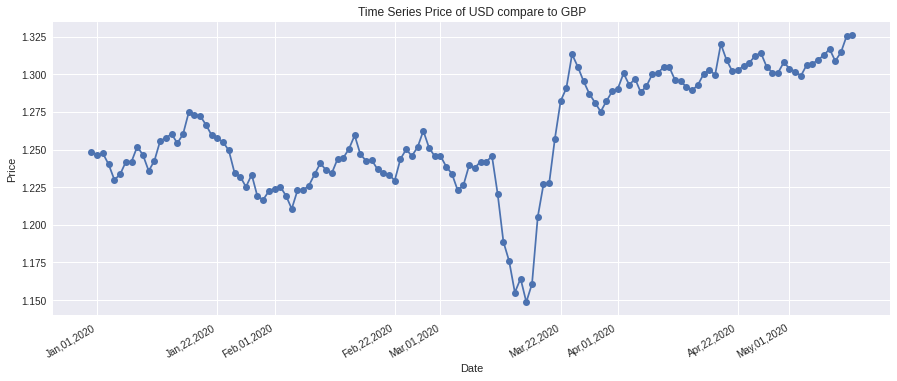

In [ ]:
# Plotted prices and dates
# Notice how the dates start and end

from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
plt.style.use('seaborn')
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,6

dates = np.array(dateFormatting['new_date'])
price = np.array(dataset['Price'])
plt.plot_date(dates,price, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Time Series Price of USD compare to GBP')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(date_format)

In [ ]:
# print(price)
test = np.array(dataset['total_deaths'])
# print(test)
price.shape
# test.shape
test = np.array(dataset['total_deaths'])
list_arr = np.array(test)
reversed_arr = list_arr[::-1]
reversed_arr.shape
price.shape

(134,)

In [ ]:
# Adds the accumulative deaths every day of a country
# Problem – This needs to be sorted from the end since the way out data is set up - can this be made more efficient?
total_us_deaths = dataset['total_deaths']
list_arr = np.array(total_us_deaths)
reversed_arr = list_arr[::-1]
newDay = 0
day = []
for currentday in reversed_arr:
   newDay = currentday + newDay
   day.append(newDay)


Text(0, 0.5, 'Total Deaths')

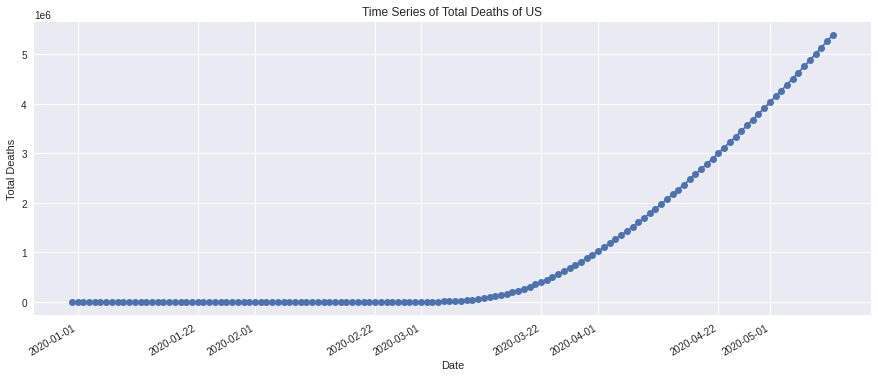

In [ ]:
# Plots the accumulative daily death rates of a country
dates = np.array(dateFormatting['new_date'])
us_deaths = np.array(day)
plt.plot_date(dates,us_deaths, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Time Series of Total Deaths of US')
plt.xlabel('Date')
plt.ylabel('Total Deaths')


In [ ]:
test.shape

(134,)

In [ ]:
price.shape

(134,)

In [ ]:
price_frame = pd.DataFrame(np.concatenate([price]), columns= ["Price"])
death_frame = pd.DataFrame(np.concatenate([day]), columns= ["Total_Deaths_US"])
price_frame.append(death_frame)

,Price,Total_Deaths_US
0,1.2482,NaN
1,1.2467,NaN
2,1.2474,NaN
3,1.2401,NaN
4,1.2299,NaN
...,...,...
129,NaN,4881974.0
130,NaN,5008114.0
131,NaN,5135524.0
132,NaN,5263586.0


# Normalisation of Features

In [ ]:
# Working Normalised method!!
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
# they are so small that is why
normalisation_us_deaths = scaler.fit_transform(death_frame).reshape(-1,1)
# loosing precision by converting to decimal but makes more readable
# but when plotting it use normalisation_us_deaths
normalisation_price = scaler.fit_transform(price_frame).reshape(-1,1)
# 8 decimal: readable formate
# val = [print("{:.8f}".format(float(x)))for x in normalisation_us_deaths]
# print(normalisation_price)
# print(val)
# print(normalisation_price)

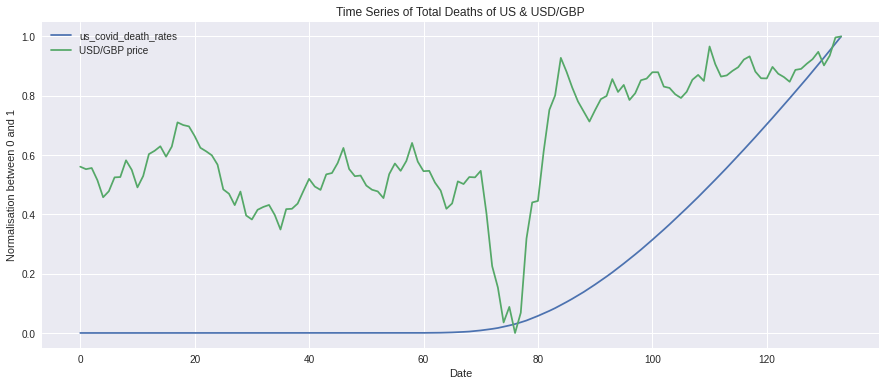

In [ ]:
# Inspect the data
# Look at join distributions of afew pairs of collumns from the training set
# Need to revise what this graph does
import matplotlib.pyplot as plt
plt.title('Time Series of Total Deaths of US & USD/GBP')
plt.plot(normalisation_us_deaths,label="us_covid_death_rates")
plt.plot(normalisation_price, label="USD/GBP price")
plt.ylabel('Normalisation between 0 and 1')
plt.xlabel('Date')
plt.legend() 
plt.show()

# Preprocessing the Data - Train, Validation & Test


In [ ]:
new_dataset = np.hstack((normalisation_us_deaths,normalisation_price))
new_dataset

array([[0.00000000e+00, 5.60879369e-01],
       [0.00000000e+00, 5.52423901e-01],
       [0.00000000e+00, 5.56369786e-01],
       [0.00000000e+00, 5.15219842e-01],
       [0.00000000e+00, 4.57722661e-01],
       [0.00000000e+00, 4.78015784e-01],
       [0.00000000e+00, 5.24802706e-01],
       [0.00000000e+00, 5.25930101e-01],
       [0.00000000e+00, 5.82299887e-01],
       [0.00000000e+00, 5.50169109e-01],
       [0.00000000e+00, 4.90980834e-01],
       [0.00000000e+00, 5.29312289e-01],
       [0.00000000e+00, 6.03156708e-01],
       [0.00000000e+00, 6.14430665e-01],
       [0.00000000e+00, 6.29650507e-01],
       [0.00000000e+00, 5.94701240e-01],
       [0.00000000e+00, 6.28523112e-01],
       [0.00000000e+00, 7.10259301e-01],
       [0.00000000e+00, 7.01240135e-01],
       [0.00000000e+00, 6.96730552e-01],
       [0.00000000e+00, 6.64036077e-01],
       [0.00000000e+00, 6.24577227e-01],
       [0.00000000e+00, 6.12739572e-01],
       [0.00000000e+00, 5.99210823e-01],
       [0.000000

In [ ]:
# Test, Validation, Train 
# This should be ordered in respect to date – not cross validation or random seed
# We are going to divide our data based on date because the next data is always dependent on the previous data
# 65% of the total length of my datadrame
# 35% test size/ validation
training_size = int(len(new_dataset)*0.65)
test_size = (len(new_dataset)-training_size)//2 # // Rounds down
train_data, valset_data, test_data = new_dataset[0:training_size], new_dataset[training_size:(training_size + test_size)],new_dataset[(training_size + test_size):]
print(train_data.shape)
print(valset_data.shape)
print(test_data.shape)

(87, 2)
(23, 2)
(24, 2)


In [ ]:
print(valset_data[:4])

[[0.12656839 0.78072153]
 [0.13825277 0.74689966]
 [0.15080431 0.71307779]
 [0.16358803 0.75197294]]


In [ ]:
training_size, test_size

(87, 23)

In [ ]:
len(train_data), len(test_data)

(87, 24)

In [ ]:
# train_data

In [ ]:
# Convert an array of values into a dataset matrix
# Go over what this method does
# time_step = how many previous days you have to consider before making a prediction
def create_dataset(dataset, time_step=1):
  dataX, dataY = [],[]
  # then we subtract e.g. timestep=3 : lendataset -3-3 so you are shifting
  # iterates from 
  # -1: guarentees 8th datapoint 
  # 100 - 1 = 99-1 =5 -> 8th
  # i is the starting point of dataset
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step)]  # i=0, 0,1,2,3
    # print(a)
    dataX.append(a)
    y = dataset[i + time_step][1] 
    dataY.append(y)
  return np.array(dataX), np.array(dataY)

In [ ]:
# weekly_timestep means taking in 7 days of features at a time 
# whats the point of writing 7 when it is assigned to 1?
weekly_timestep = 7
X_train, Y_train = create_dataset(train_data, weekly_timestep)
X_val, Y_val = create_dataset(valset_data, weekly_timestep)
X_test, Y_test = create_dataset(test_data, weekly_timestep)



In [ ]:
print(X_test.shape), print(Y_test.shape)
# Finished preprocessing the data

(16, 7, 2)
(16,)


(None, None)

# Stacked LSTM Model

In [ ]:
# Create the stacked LSTM model
# One LSTM after the other
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import InputLayer
# 5, 
def lstm_model(hidden_layer, optimizer):
  model = Sequential()
  model.add(InputLayer(input_shape=(7,2)))
  model.add(LSTM(hidden_layer,return_sequences=True))
  model.add(LSTM(hidden_layer, return_sequences=True))
  model.add(LSTM(hidden_layer))
  model.add(Dense(1))
  model.compile(loss = 'mean_squared_error', optimizer=optimizer)
  return model

## Hyperparameter Tuning


*   Optimizers:
[Overview of different Optimizers for neural networks](https://medium.com/datadriveninvestor/overview-of-different-optimizers-for-neural-networks-e0ed119440c3#:~:text=Adagrad%20eliminates%20the%20need%20to,is%20no%20longer%20able%20learning.)





In [86]:
# Grid Search
# Candidates for good hidden layers and optimiser
# tests 5 adam optimizer, 6 otimizer systemtically for each one
# Random does some of all
# Random search: does single for loop with no of samples for each, and randomly select one from each list
# testing each hyperpara against every other hyper

# Choose the number of hidden layers.
hidden_layer = [5, 6, 2, 1, 4, 5, 4, 7]
# Choose the optimizers you want to use.
optimizers = ['SGD', 'RMSprop','adam','adagrad', 'adadelta', 'adamax','nadam', 'ftrl']
# Consider changing batch size: slower the batch_size better training, because small dataset
for every_point in hidden_layer:
  for every_hidden_layer_value in optimizers:
    model_testing = lstm_model(every_point, every_hidden_layer_value)
    model_testing.fit(X_train, Y_train, 
          validation_data= (X_val, Y_val), 
          epochs=5,batch_size=32,verbose=1,
           callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)])
                      
  ## restore best weights is going to give u best model 
  # make graph that against loss
  # learning rate as optimizer???? inidivual number of hidden layers for random search
  

Epoch 1/5
3/3 [==============================] - 1s 276ms/step - loss: 0.2982 - val_loss: 0.7141
Epoch 2/5
3/3 [==============================] - 0s 14ms/step - loss: 0.2139 - val_loss: 0.5901
Epoch 3/5
3/3 [==============================] - 0s 15ms/step - loss: 0.1561 - val_loss: 0.4967
Epoch 4/5
3/3 [==============================] - 0s 15ms/step - loss: 0.1161 - val_loss: 0.4215
Epoch 5/5
3/3 [==============================] - 0s 14ms/step - loss: 0.0875 - val_loss: 0.3655
Epoch 1/5
3/3 [==============================] - 1s 283ms/step - loss: 0.2564 - val_loss: 0.5731
Epoch 2/5
3/3 [==============================] - 0s 17ms/step - loss: 0.2221 - val_loss: 0.5187
Epoch 3/5
3/3 [==============================] - 0s 15ms/step - loss: 0.1965 - val_loss: 0.4684
Epoch 4/5
3/3 [==============================] - 0s 15ms/step - loss: 0.1729 - val_loss: 0.4188
Epoch 5/5
3/3 [==============================] - 0s 16ms/step - loss: 0.1502 - val_loss: 0.3685
Epoch 1/5
3/3 [=======================

# Predicted the test data 

*   Must also plot the output



In [87]:
# Prediction and check performance metric
train_predict = model_testing.predict(X_train)
test_predict = model_testing.predict(X_test)
train_predict.shape
test_predict.shape

(16, 1)

In [88]:
# Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
train_predict.shape

(79, 1)

In [89]:
# Calculate the RMSE performance metrics
# Output for the train dataset
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(Y_train, train_predict))

0.665752998759376

In [90]:
# Similarly for the test Data RMSE
math.sqrt(mean_squared_error(Y_test, test_predict))

0.25237193083372994

In [91]:
# Evaluating: How well is model performing 
# Probability distribution rather than time series
# Tensorflow??
# KL Divergence
# Consider this for evaluation: https://www.tensorflow.org/api_docs/python/tf/keras/losses/KLDivergence
# kl divergence measures difference between 2 probability distributions, 
# measure of what i am predicting and what should have been predicting

# Predicted future 7 days and plotted the output

(134, 2)
(134, 2)


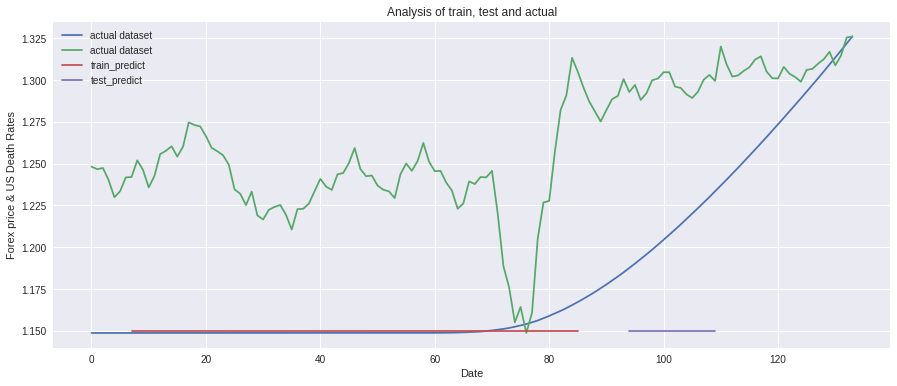

In [92]:
# What does this mean exactly??

look_back = 7

# empty_like: Return a new array with the same shape and type as a given array.
# np.nan: Replect all with nan? What does this mean?
# What does this do?? 7: predict.length() + 7, :

trainPredictPlot = np.empty_like(new_dataset)
trainPredictPlot[:,:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print(trainPredictPlot.shape)

# empty_like: Return a new array with the same shape and type as a given array.
# np.nan: Replect all with nan? What does this mean?
# Dont understand what this is doing
# What does this do?? predict.length() + (7*2) +2 :(training_size + test_size)] = test_predict

testPredictPlot = np.empty_like(new_dataset)
testPredictPlot[:,:]= np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1: (training_size + test_size)] = test_predict
# new_dataset[training_size:(training_size + test_size)]
print(testPredictPlot.shape)

# Plot baseline and predictions
plt.title('Analysis of train, test and actual')
plt.plot(scaler.inverse_transform(new_dataset), label="actual dataset")

# plt.plot(train_predict)
# plt.plot(test_predict)

trainPredictPlot = [item[1] for item in trainPredictPlot] 
plt.plot(trainPredictPlot, label="train_predict")
testPredictPlot = [item[1] for item in testPredictPlot] 
plt.plot(testPredictPlot, label="test_predict")

# as you can see th test data and train is divided because we want to test after a specific day
# plt.plot(testPredictPlot, label="test_predict")
plt.ylabel('Forex price & US Death Rates')
plt.xlabel('Date')
plt.legend()
plt.show()
# Printing 2 actual_dataset, train_predict, test_predict because 2 input layers

# Custom 4 day predictiom


*   Training train data to predict future days and evaluating the accuracy on validation data.
*   Training train data to predict future days, no way of evaluating however this can tell us what is likely to occur.



### Using last 7 days of training data to predict the future custom days(4). 

In [93]:
# What does this do?
X_input=test_data[40:].reshape(1,-1)
X_input.shape
temp_input = train_data[-7:]
temp_input


array([[0.05753473, 0.44532131],
       [0.0658916 , 0.61217587],
       [0.07456764, 0.75253664],
       [0.08383321, 0.80101466],
       [0.09400989, 0.92784667],
       [0.10444046, 0.88105975],
       [0.11526232, 0.82750846]])

In [95]:
# Demonstrate prediction for the next 4 days:

# Step 1. 7 days of feature = temp_input taken from the last 7 days of the training set
# Step 2  i is the day you are on and we want to predict 4 days: 0,1,2,3 (4 days)
# Step 3. Predict the 8th day on each of the 7 days,
# Step 4. Add this new predicted day to the list
# Step 5. Because we are now taking in the last 7 days + the new predicted value, the list is now size 8  
# Step 6. In order to take in 7 days at a time, we shift 1 to the right.
# Step 7. We reassign the X_train to the new 7 days
# Step 8. We predict the 8th day of the 7 days and continue the process
# Step 9. We then add the 8th day to the output list
# Step 10. We keep track of the 4 days by incrementing by i at the end-> i = i+1
# Step 11. Once we have predicted the 4 days, we return the list of 4 day values.

from numpy import array
custom_day = 4
lst_output=[]
n_steps=7
i=0
X_input = temp_input
while(i<custom_day):
  if(len(temp_input)>7):
    # print(temp_input)  
    X_input=array(temp_input[1:])
    # print("{} day input {}".format(i,X_input))
    # Correct input shape (1,7,2)
    X_input=X_input.reshape((1,n_steps,2))
    # Prediction of X_input
    Y_hat = model_testing.predict(X_input)
    temp_input = np.append(temp_input, Y_hat)
    temp_input=temp_input[1:]
    lst_output.append(Y_hat[0][0])
    i=i+1
  else:
    X_input=X_input.reshape((1,n_steps,2))
    Y_hat = model_testing.predict(X_input, verbose=0)
    temp_input = np.append(temp_input, Y_hat)
    lst_output.append(Y_hat[0][0])
    i=i+1

# Print the predicted forex price for the next 4 days 
print(lst_output)

[0.006342962, 0.006342962, 0.006342962, 0.006342962]


### Plotting evaluation on graph. Training output versus first 4 days of the validation data.

[0.00634296 0.00634296 0.00634296 0.00634296]
[0.7807215332581725, 0.746899661781284, 0.7130777903043954, 0.7519729425028183]


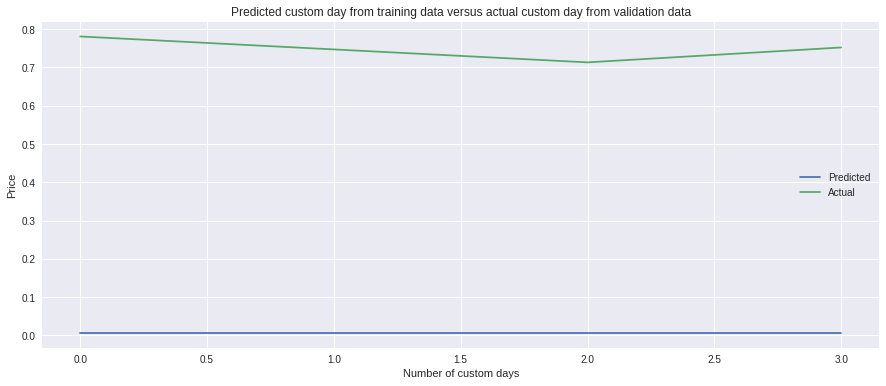

In [96]:
# Custom day plotted
day_new = custom_day-1

# Predicted 4 days from training
# Plot and label
# Transform back to original value before normalised
custom_day_prediction = np.array(lst_output)
print(custom_day_prediction)
plt.plot(custom_day_prediction, label="Predicted")
# plt.plot(day_new, scaler.inverse_transform([custom_day_prediction]))

# Actual 4 days from validation
# Plot and label
# Transform back to original value before normalised
val_data = [item[1] for item in valset_data] 
custom_day_validation = val_data[:custom_day]
print(custom_day_validation)
plt.plot(custom_day_validation, label="Actual")
# plt.plot(day_new, scaler.inverse_transform([custom_day_validation]))

# Information
plt.title('Predicted custom day from training data versus actual custom day from validation data')
plt.xlabel('Number of custom days')
plt.ylabel('Price')
plt.legend()
plt.show()

[0.00634296 0.00634296 0.00634296 0.00634296]


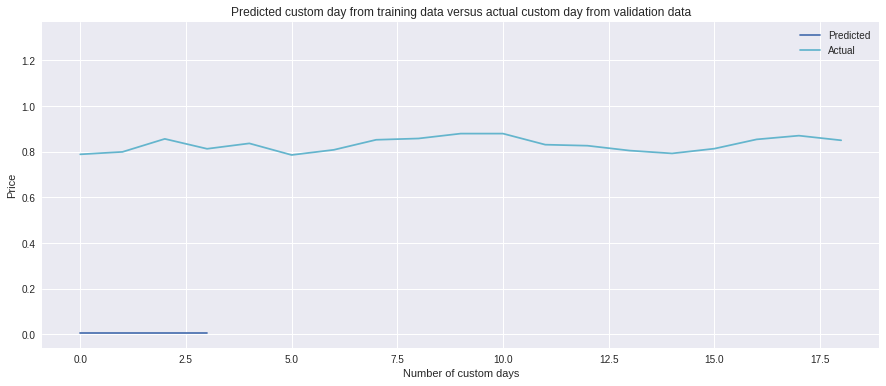

In [97]:
# Connect what we got as a result to the future
day_new = custom_day-1

# Predicted 4 days from training
# Plot and label
# Transform back to original value before normalised
custom_day_prediction = np.array(lst_output)
print(custom_day_prediction)
plt.plot(custom_day_prediction, label="Predicted")
plt.plot(day_new, scaler.inverse_transform([custom_day_prediction]))

# Actual 4 days from validation
# Plot and label
# Transform back to original value before normalised
# Start on 4 instead
val_data = [item[1] for item in valset_data] 
custom_day_validation = val_data[custom_day:]
plt.plot(custom_day_validation, label="Actual")
plt.plot(day_new, scaler.inverse_transform([custom_day_validation]))

# Information
plt.title('Predicted custom day from training data versus actual custom day from validation data')
plt.xlabel('Number of custom days')
plt.ylabel('Price')
plt.legend()
plt.show()



In [ ]:
# What we have:
# day_new=np.arange(1,8)
# print(day_new)
# What we want to predict:
# day_pred=np.arange(8,12)
# print(day_pred)

In [ ]:
# Grid Search
# Every hyperpara combination we have

# Conclusion and next steps
We explored the LSTM algorithms:

*   List item
*   List item


In conclusion it seems that ..